In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os

2021-12-16 11:14:57.827946: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-16 11:14:57.827974: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# 데이터 불러오기
df = pd.read_csv('gooreview.csv', encoding='UTF-8')
df.head()

,날짜,리뷰 내용,평점(5개 만점)
0,2021년 10월,아침 일찍 와도 주차장이 여유롭지 않지만 여러가지 기구들도 많고 아이들과 놀기 너무...,5.0
1,2021년 10월,"아이들이 좋아하고, 재있어요",5.0
2,2021년 10월,가족들과 즐건주말 위드코로나되면 더북적북적 해지겠지?,5.0
3,2021년 10월,오후4시에 들어가서 밤 9시 30분까지 알차게 놀았어요^^ 엄청 혼잡하긴 했지만 거...,5.0
4,2021년 10월,"유아, 어린이가 놀기에 최고의 놀이공원~",5.0


In [3]:
df.columns=['date','document','label']

In [4]:
df.head()

,date,document,label
0,2021년 10월,아침 일찍 와도 주차장이 여유롭지 않지만 여러가지 기구들도 많고 아이들과 놀기 너무...,5.0
1,2021년 10월,"아이들이 좋아하고, 재있어요",5.0
2,2021년 10월,가족들과 즐건주말 위드코로나되면 더북적북적 해지겠지?,5.0
3,2021년 10월,오후4시에 들어가서 밤 9시 30분까지 알차게 놀았어요^^ 엄청 혼잡하긴 했지만 거...,5.0
4,2021년 10월,"유아, 어린이가 놀기에 최고의 놀이공원~",5.0


In [5]:
print('테스트용 리뷰 개수 :',len(df))

테스트용 리뷰 개수 : 240


### 데이터 정제 하기

In [6]:
# 데이터 중복 확인
df.nunique()

date         12
document    229
label         5
dtype: int64

In [7]:
print(df.groupby('label').size().reset_index(name = 'count'))

   label  count
0    1.0      6
1    2.0      5
2    3.0     23
3    4.0     68
4    5.0    127


In [8]:
print('총 샘플의 수 :',len(df))

총 샘플의 수 : 240


In [9]:
# 한글과 공백을 제외하고 모두 제거
df['document'] = df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [10]:
# 결측값 제거
df = df.dropna(axis=0)

In [11]:
df.head()

,date,document,label
0,2021년 10월,아침 일찍 와도 주차장이 여유롭지 않지만 여러가지 기구들도 많고 아이들과 놀기 너무...,5.0
1,2021년 10월,아이들이 좋아하고 재있어요,5.0
2,2021년 10월,가족들과 즐건주말 위드코로나되면 더북적북적 해지겠지,5.0
3,2021년 10월,오후시에 들어가서 밤 시 분까지 알차게 놀았어요 엄청 혼잡하긴 했지만 거의 모든 놀...,5.0
4,2021년 10월,유아 어린이가 놀기에 최고의 놀이공원,5.0


In [12]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','방문일일','방문일']
okt = Okt()

In [13]:
X_train = []
for sentence in tqdm(df['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████| 229/229 [00:05<00:00, 41.63it/s]


In [14]:
print(X_train[:3])

[['아침', '일찍', '와도', '주차장', '여유롭다', '않다', '여러가지', '기구', '많다', '아이', '놀다', '너무', '좋다', '맛있다', '레스토랑', '이라고', '어렵다', '돈까스', '우동', '등', '그냥', '무난', '식당', '좋다', '끼어들다', '대해', '서', '조금', '더', '엄격하다', '감독', '바램', '이다'], ['아이', '좋아하다', '재다'], ['가족', '즐겁다', '위드', '코로나', '되다', '더', '북적', '북적', '해지', '겠다']]


### 정수 인코딩
+ 기계가 텍스트를 숫자로 처리할 수 있도록 정수 인코딩을 수행

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [16]:
print(tokenizer.word_index)

{'좋다': 1, '있다': 2, '아이': 3, '많다': 4, '놀이기구': 5, '을': 6, '놀다': 7, '이다': 8, '않다': 9, '없다': 10, '사람': 11, '너무': 12, '곳': 13, '것': 14, '가다': 15, '많이': 16, '오다': 17, '랜드': 18, '타다': 19, '다': 20, '놀이': 21, '코로나': 22, '공원': 23, '재미있다': 24, '보다': 25, '시간': 26, '같다': 27, '탈': 28, '만': 29, '로': 30, '시설': 31, '수': 32, '서': 33, '되다': 34, '좋아하다': 35, '정말': 36, '더': 37, '에서': 38, '다녀오다': 39, '서울': 40, '아쉽다': 41, '에는': 42, '어리다': 43, '제공': 44, '즐겁다': 45, '시': 46, '고': 47, '기구': 48, '가족': 49, '재밌다': 50, '최고': 51, '함께': 52, '번역': 53, '세': 54, '평일': 55, '울': 56, '나': 57, '넓다': 58, '때': 59, '비': 60, '정도': 61, '안': 62, '요': 63, '하루': 64, '줄': 65, '게': 66, '오랜': 67, '넘다': 68, '애': 69, '가격': 70, '자다': 71, '조금': 72, '분': 73, '까지': 74, '거의': 75, '어린이': 76, '기다리다': 77, '다양하다': 78, '적': 79, '에버랜드': 80, '할인': 81, '만원': 82, '먹다': 83, '저': 84, '이라': 85, '추억': 86, '들다': 87, '놀이동산': 88, '운영': 89, '그래도': 90, '그렇다': 91, '야간': 92, '가기': 93, '다니다': 94, '날': 95, '랑': 96, '장소': 97, '키': 98, '그냥': 99, '하고': 100, '유아': 101,

In [17]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 1203
등장 빈도가 2번 이하인 희귀 단어의 수: 887
단어 집합에서 희귀 단어의 비율: 73.73233582709892
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 28.825717321997875


In [18]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 317


In [19]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)

In [20]:
print(X_train[:3])

[[230, 133, 9, 48, 4, 3, 7, 12, 1, 176, 231, 99, 1, 33, 72, 37, 8], [3, 35, 232], [49, 45, 22, 34, 37]]


In [21]:
y_train = np.array(df['label'])

In [22]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [23]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

227
227


/home/hadoop/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 115
리뷰의 평균 길이 : 11.801762114537445


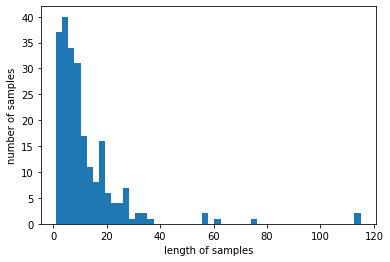

In [24]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [25]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [26]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 95.15418502202643


In [27]:
X_train = pad_sequences(X_train, maxlen = max_len)

### LSTM으로 영화 리뷰 하기

In [28]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [29]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

2021-12-16 11:15:06.436068: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-16 11:15:06.454182: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-16 11:15:06.454344: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost.localdomain): /proc/driver/nvidia/version does not exist
2021-12-16 11:15:06.473981: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [31]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

2021-12-16 11:15:07.487526: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-16 11:15:07.503412: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3192000000 Hz


Epoch 1/15
3/3 [==============================] - 2s 203ms/step - loss: -0.0434 - acc: 0.0110 - val_loss: -10.9803 - val_acc: 0.0217

Epoch 00001: val_acc improved from -inf to 0.02174, saving model to best_model.h5
Epoch 2/15
3/3 [==============================] - 0s 48ms/step - loss: -19.6908 - acc: 0.0276 - val_loss: -31.4507 - val_acc: 0.0217

Epoch 00002: val_acc did not improve from 0.02174
Epoch 3/15
3/3 [==============================] - 0s 47ms/step - loss: -33.5286 - acc: 0.0276 - val_loss: -38.6206 - val_acc: 0.0217

Epoch 00003: val_acc did not improve from 0.02174
Epoch 4/15
3/3 [==============================] - 0s 44ms/step - loss: -39.8036 - acc: 0.0276 - val_loss: -43.6858 - val_acc: 0.0217

Epoch 00004: val_acc did not improve from 0.02174
Epoch 5/15
3/3 [==============================] - 0s 43ms/step - loss: -44.4343 - acc: 0.0276 - val_loss: -47.5079 - val_acc: 0.0217

Epoch 00005: val_acc did not improve from 0.02174
Epoch 6/15
3/3 [==============================] 

In [32]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_train, y_train)[1]))

8/8 [==============================] - 0s 8ms/step - loss: -11.2736 - acc: 0.0264

 테스트 정확도: 0.0264


### 리뷰 예측해보기

In [33]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [34]:
sentiment_predict('아이')

98.00% 확률로 긍정 리뷰입니다.

